In [1]:
#Script for Amyloid detection using 2D CNN from ADNI dataset
#Tamoghna Chattopadhyay

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "6"


In [3]:
!pip install tensorflow==2.5.0

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.4 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
!pip install tensorflow-addons==0.15.0

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: pytorch-lightning 1.6.4 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random as pyrandom
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory

import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, auc, roc_auc_score
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score


physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2025-02-04 02:20:39.487447: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  1


2025-02-04 02:20:58.264356: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2025-02-04 02:20:58.569896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-02-04 02:20:58.569990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-02-04 02:20:58.578661: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-02-04 02:20:58.578831: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2025-02-04 02:20:58.584494: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

In [6]:
from tensorflow.keras import backend as K 
K.clear_session()

In [7]:
#Hyperparameter Configuration

ini_learning_rate = 1e-4
epochs = 50
early_stop = 100
seed_num = 7
drop_out = 0.5
wd = 1e-4

batch_size = 1
test_batch_size = 1

In [8]:
#Set the seed
pyrandom.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.ndimage import zoom
import os
import nibabel as nib
from sklearn.preprocessing import LabelEncoder

# Function to read and process the scans
def read_volume_file(filepath):
    """Read and load volume from .npy or .nii/.nii.gz files."""
    if filepath.endswith('.npy'):
        volume = np.load(filepath)  # Load .npy file
    elif filepath.endswith('.nii') or filepath.endswith('.nii.gz'):
        scan = nib.load(filepath)
        volume = scan.get_fdata()
    else:
        raise ValueError(f"Unsupported file type for {filepath}")
    
    return volume

def normalize(volume):
    """Normalize the volume."""
    dmin = np.amin(volume)
    dmax = np.amax(volume)
    volume = (volume - dmin) / (dmax - dmin)
    volume = volume.astype("float32")
    return volume

def resize_volume(volume, target_size=(128, 128)):
    """Resize volume to the target size."""
    if len(volume.shape) != 2:
        raise ValueError(f"Unexpected volume shape: {volume.shape}. Expected 2 dimensions.")
    
    scale = [t / s for t, s in zip(target_size, volume.shape)]
    volume = zoom(volume, scale, order=1)  # Resize using linear interpolation
    return volume

def process_scan(path):
    """Read, normalize, and resize volume."""
    volume = read_volume_file(path)
    print(f"Volume shape before squeezing: {volume.shape}")  # Debugging
    volume = np.squeeze(volume)  # Remove extra dimensions
    print(f"Volume shape after squeezing: {volume.shape}")  # Debugging
    if len(volume.shape) != 2:
        raise ValueError(f"Unexpected volume shape: {volume.shape}. Expected 2 dimensions.")
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

def train_preprocessing(x, y):
    """Preprocess training data."""
    x = tf.expand_dims(x, axis=-1) #TensorFlow models, especially CNNs, expect input images to have at least 3 dimensions
    x = tf.image.per_image_standardization(x)  # Normalize image
    return x, y


def validation_preprocessing(x, y):
    """Preprocess validation data."""
    x = tf.expand_dims(x, axis=-1)
    x = tf.image.per_image_standardization(x)  # Normalize image
    return x, y

def test_preprocessing(x, y):
    """Preprocess test data."""
    x = tf.expand_dims(x, axis=-1) # Add channel dimension (128, 128) -> (128, 128, 1)
    x = tf.image.per_image_standardization(x)  # Normalize image
    return x, y

# Read CSV files
train_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/vdesai/ADNI/training.csv")
val_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/vdesai/ADNI/validation.csv")
test_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/vdesai/ADNI/testing.csv")	
# test_df = pd.read_csv("/ifs/loni/faculty/thompson/four_d/rkush/Real Dataset/testing.csv")

# Extract paths and labels
train_paths = train_df['Location'].tolist()
train_labels = train_df['DX'].tolist()

val_paths = val_df['Location'].tolist()
val_labels = val_df['DX'].tolist()

test_paths = test_df['Location'].tolist()
test_labels = test_df['DX'].tolist()

# Process scans and convert labels to NumPy arrays
x_train = []
for path in train_paths:
    try:
        x_train.append(process_scan(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")
x_train = np.array(x_train)

x_val = []
for path in val_paths:
    try:
        x_val.append(process_scan(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")
x_val = np.array(x_val)

x_test = []
for path in test_paths:
    try:
        x_test.append(process_scan(path))
    except Exception as e:
        print(f"Error processing {path}: {e}")
x_test = np.array(x_test)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

# Convert to TensorFlow datasets
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))



# Define data loaders and augment the data on the fly during training
train_dataset = (
    train_loader.shuffle(len(x_train), seed=7)
    .map(train_preprocessing)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val), seed=7)
    .map(validation_preprocessing)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_loader.map(test_preprocessing)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)

# Print confirmation
print("Data loaded, reshaped, encoded, and preprocessed successfully.")
print("New shape of a single training image:", x_train[0].shape)
# print("New shape of a single validation image:", x_val[0].shape)
print("New shape of a single testing image:", x_test[0].shape)


Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezing: (91, 109)
Volume shape after squeezing: (91, 109)
Volume shape before squeezin

2025-02-04 02:21:00.420556: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 02:21:00.428523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-02-04 02:21:00.431076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2025-02-04 02:21:00.431148: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2025-02-04 02:21:03.299478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnec

Data loaded, reshaped, encoded, and preprocessed successfully.
New shape of a single training image: (128, 128)
New shape of a single testing image: (128, 128)


In [10]:
print("Number of samples for train, validation and test are %d, %d, and %d." % (x_train.shape[0], x_val.shape[0], x_test.shape[0]))
# print("Number of samples for train, validation and test are %d and %d." % (x_train.shape[0], x_test.shape[0]))

Number of samples for train, validation and test are 250, 45, and 37.


In [11]:
print("New shape of a single training image:", x_train[0].shape)
print("New shape of a single validation image:", x_val[0].shape)
print("New shape of a single testing image:", x_test[0].shape)

New shape of a single training image: (128, 128)
New shape of a single validation image: (128, 128)
New shape of a single testing image: (128, 128)


In [12]:
print("Shape of a single training image:", x_train[0].shape) #old 182, 218, 182
print("Shape of a single testing image:", x_test[0].shape)
print("Shape of a single validation image:", x_val[0].shape)

Shape of a single training image: (128, 128)
Shape of a single testing image: (128, 128)
Shape of a single validation image: (128, 128)


In [13]:
@tf.function
# def rotate(volume):
#     """Rotate the volume by a few degrees"""

#     def scipy_rotate(volume):
#         # define some rotation angles
#         angles = [-20, -10, -5, 5, 10, 20]
#         # pick angles at random
#         angle = pyrandom.choice(angles)
#         # rotate volume
#         volume = ndimage.rotate(volume, angle, reshape=False)
#         volume[volume < 0] = 0
#         volume[volume > 1] = 1
#         return volume

#     augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
#     return augmented_volume

def rotate(volume):
    """Enhanced augmentation function"""
    def scipy_rotate(volume):
        # Random rotation
        angle = np.random.uniform(-20, 20)
        volume = ndimage.rotate(volume, angle, reshape=False)
        
        # Random horizontal flip
        if np.random.random() > 0.5:
            volume = np.fliplr(volume)
        
        # Random vertical flip
        if np.random.random() > 0.5:
            volume = np.flipud(volume)
            
        # Random brightness adjustment
        volume = volume * np.random.uniform(0.8, 1.2)
        
        # Clip values
        volume = np.clip(volume, 0, 1)
        return volume
        
    augmented_volume = tf.numpy_function(numpy_augment, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label
    

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = pyrandom.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label
    

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

def test_preprocessing(volume, label):
    """Process test data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

def test_preprocessing(volume, label):
    """Process test data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=-1)
    return volume, label

In [14]:
#Define data loaders
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#Augment the data on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train), seed = seed_num)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val), seed = seed_num)
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(batch_size)
)

test_dataset = (
    test_loader.map(test_preprocessing).batch(batch_size).prefetch(batch_size)
)

Dimension of the MRI scan is: (128, 128, 1)


2025-02-04 02:21:03.977998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2025-02-04 02:21:03.979002: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2300000000 Hz


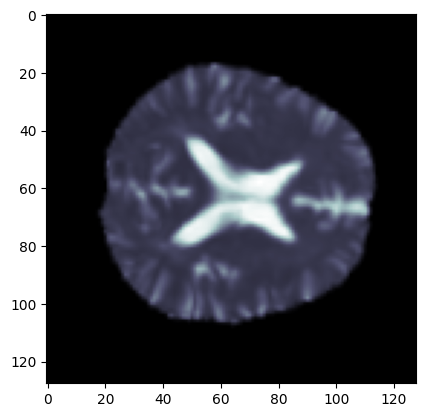

In [15]:
%matplotlib inline
data = train_dataset.take(1)
images, labels = list(data)[0]
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
# norm_image = (image[:, :, 45] - np.min(image[:, :, 45])) / (np.max(image[:, :, 45]) - np.min(image[:, :, 45]))
plt.imshow(np.squeeze(image), cmap="bone")
# plt.imshow(np.squeeze(image[:, :, 45]), cmap="bone")

In [16]:
'''%matplotlib inline
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


#Visualize montage of slices.
plot_slices(4, 10, 91, 109, image[:, :, :40])'''

'%matplotlib inline\ndef plot_slices(num_rows, num_columns, width, height, data):\n    """Plot a montage of 20 MRI slices"""\n    data = np.rot90(np.array(data))\n    data = np.transpose(data)\n    data = np.reshape(data, (num_rows, num_columns, width, height))\n    rows_data, columns_data = data.shape[0], data.shape[1]\n    heights = [slc[0].shape[0] for slc in data]\n    widths = [slc.shape[1] for slc in data[0]]\n    fig_width = 12.0\n    fig_height = fig_width * sum(heights) / sum(widths)\n    f, axarr = plt.subplots(\n        rows_data,\n        columns_data,\n        figsize=(fig_width, fig_height),\n        gridspec_kw={"height_ratios": heights},\n    )\n    for i in range(rows_data):\n        for j in range(columns_data):\n            axarr[i, j].imshow(data[i][j], cmap="gray")\n            axarr[i, j].axis("off")\n    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)\n    plt.show()\n\n\n#Visualize montage of slices.\nplot_slices(4, 10, 91, 109, image[:

In [17]:
# def plot_slices(num_rows, num_columns, width, height, data):
#     """Plot a montage of MRI slices."""
#     data = np.rot90(np.array(data))
#     data = np.transpose(data)
#     data = np.reshape(data, (num_rows, num_columns, width, height))
#     rows_data, columns_data = data.shape[0], data.shape[1]
#     heights = [slc[0].shape[0] for slc in data]
#     widths = [slc.shape[1] for slc in data[0]]
#     fig_width = 12.0
#     fig_height = fig_width * sum(heights) / sum(widths)
#     f, axarr = plt.subplots(
#         rows_data,
#         columns_data,
#         figsize=(fig_width, fig_height),
#         gridspec_kw={"height_ratios": heights},
#     )
#     for i in range(rows_data):
#         for j in range(columns_data):
#             axarr[i, j].imshow(data[i][j], cmap="gray")
#             axarr[i, j].axis("off")
#     plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
#     plt.show()


# # Adjust parameters for your 64x64x64 image
# num_rows = 4
# num_columns = 4
# slices_to_display = num_rows * num_columns  # 16 slices
# data = image[:, :, :slices_to_display]  # Extract 16 slices for the montage

# # Update the width and height to match the new dimensions
# plot_slices(num_rows, num_columns, 64, 64, data)


In [18]:
#2D model

def get_model(width=128, height=128, drop_out=0.5):#before 0.3
    
    def convolution_block(inputs, num_filter, name):
        # inputs = tf.keras.layers.Conv2D(num_filter, 3, strides=1, padding="same")(inputs)
        inputs = tf.keras.layers.Conv2D(
            num_filter, 3, strides=1, padding="same",
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )(inputs)
        inputs = tf.keras.layers.BatchNormalization()(inputs)
        inputs = tf.keras.layers.MaxPooling2D(2, strides=2, padding="valid")(inputs)
        inputs = tf.nn.relu(inputs)
        return inputs
    
    # Input layer
    images = tf.keras.Input((width, height, 1))
    
    # Convolution blocks
    inputs = convolution_block(images, 32, "conv_block1")  # Output: 32x32x32x32
    inputs = convolution_block(inputs, 64, "conv_block2")  # Output: 16x16x16x64
    inputs = convolution_block(inputs, 128, "conv_block3")  # Output: 8x8x8x128
    inputs = convolution_block(inputs, 256, "conv_block4")
    
    
    # Last Conv2D layer
    inputs = tf.keras.layers.Conv2D(64, 1, strides=1, name="post_conv")(inputs)
    inputs = tfa.layers.InstanceNormalization(center=False, scale=False)(inputs)
    # inputs = tf.keras.layers.BatchNormalization(name="post_batchnorm")(inputs)
    inputs = tf.nn.relu(inputs, name="post_relu")
    inputs = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=2, name="post_avg_pool")(inputs)  # Output: 4x4x4x64
    
    # Dropout
    inputs = tf.keras.layers.Dropout(rate=drop_out, name="drop")(inputs)
    
    # Flatten and Dense output
    outputs = tf.keras.layers.Flatten(name="flatten")(inputs)
    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid", name="predicted_class")(outputs)
    
    # Define model
    model = tf.keras.Model(images, outputs, name="2dcnn")
    return model

In [19]:
# def Conv_2D_Block(inputs, model_width, kernel, strides):
#     """2D Convolutional Block with BatchNormalization and ReLU."""
#     x = tf.keras.layers.Conv2D(
#         model_width, kernel, strides=strides, padding="same", kernel_initializer="he_normal"
#     )(inputs)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation("relu")(x)
#     return x


# def stem(inputs, num_filters):
#     """Construct the Stem Convolution Group."""
#     x = Conv_2D_Block(inputs, num_filters, (7, 7), (2, 2))
#     x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)
#     return x


# def conv_block(x, num_filters, bottleneck=True):
#     """Block of Convolutions without Pooling."""
#     if bottleneck:
#         num_filters_bottleneck = num_filters * 4
#         x = Conv_2D_Block(x, num_filters_bottleneck, (1, 1), (1, 1))
#     out = Conv_2D_Block(x, num_filters, (3, 3), (1, 1))
#     return out


# def dense_block(x, num_filters, num_layers, bottleneck=True):
#     """Dense Block with multiple convolution layers."""
#     for _ in range(num_layers):
#         cb = conv_block(x, num_filters, bottleneck=bottleneck)
#         x = tf.keras.layers.concatenate([x, cb], axis=-1)
#     return x


# def transition_block(inputs, num_filters):
#     """Transition Block between Dense Blocks."""
#     x = Conv_2D_Block(inputs, num_filters, (1, 1), (1, 1))
#     x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
#     return x


# def classifier(inputs):
#     """Classifier Layer for Binary Classification."""
#     out = tf.keras.layers.Dense(1, activation="sigmoid")(inputs)
#     return out


# class DenseNet:
#     def __init__(self, length, width, num_channel, num_filters, dropout_rate=0.3):
#         self.length = length
#         self.width = width
#         self.num_channel = num_channel
#         self.num_filters = num_filters
#         self.dropout_rate = dropout_rate

#     def DenseNet121(self):
#         inputs = tf.keras.Input((self.length, self.width, self.num_channel))

#         # Stem block
#         x = stem(inputs, self.num_filters)

#         # DenseNet-121 architecture
#         x = dense_block(x, self.num_filters, 6, bottleneck=True)
#         x = transition_block(x, self.num_filters)
#         x = dense_block(x, self.num_filters * 2, 12, bottleneck=True)
#         x = transition_block(x, self.num_filters * 2)
#         x = dense_block(x, self.num_filters * 4, 24, bottleneck=True)
#         x = transition_block(x, self.num_filters * 4)
#         x = dense_block(x, self.num_filters * 8, 16, bottleneck=True)

#         # Global Average Pooling
#         x = tf.keras.layers.GlobalAveragePooling2D()(x)

#         # Dropout
#         if self.dropout_rate:
#             x = tf.keras.layers.Dropout(self.dropout_rate)(x)

#         # Classification layer
#         outputs = classifier(x)

#         # Define model
#         model = tf.keras.Model(inputs, outputs, name="DenseNet121")
#         return model

In [20]:
model = get_model(width=128, height=128)
model.summary()

Model: "2dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256   

In [21]:
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)  # Should print (128, 128, 1)
    print("Label shape:", label.shape)

Image shape: (1, 128, 128, 1)
Label shape: (1,)


In [22]:
print(next(iter(train_dataset.take(1)))[0].shape)
print(next(iter(train_dataset.take(1)))[1].shape)



(1, 128, 128, 1)
(1,)


In [23]:
for batch in train_dataset.take(1):
    print(batch[0].shape)  # Inputs
    print(batch[1].shape)  # Labels


(1, 128, 128, 1)
(1,)


In [24]:
# from sklearn.model_selection import KFold
# import numpy as np
# import tensorflow as tf

# def train_with_kfold(x_data, y_data, n_splits=5):
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed_num)
#     fold_scores = []
#     models = []
    
#     for fold, (train_idx, val_idx) in enumerate(kfold.split(x_data)):
#         print(f'\nTraining fold {fold + 1}/{n_splits}')
        
#         # Split data for this fold
#         x_train_fold = x_data[train_idx]
#         y_train_fold = y_data[train_idx]
#         x_val_fold = x_data[val_idx]
#         y_val_fold = y_data[val_idx]
        
#         # Create datasets for this fold
#         train_dataset = (
#             tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
#             .shuffle(len(x_train_fold), seed=seed_num)
#             .map(train_preprocessing)
#             .batch(batch_size)
#             .prefetch(tf.data.AUTOTUNE)
#         )
        
#         validation_dataset = (
#             tf.data.Dataset.from_tensor_slices((x_val_fold, y_val_fold))
#             .map(validation_preprocessing)
#             .batch(batch_size)
#             .prefetch(tf.data.AUTOTUNE)
#         )
        
#         # Create and compile model for this fold
#         K.clear_session()  # Clear session to avoid memory issues
#         model = get_model(width=128, height=128)
        
#         # Compile model with your existing settings
#         lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
#             initial_learning_rate=0.001,
#             first_decay_steps=1000,
#             t_mul=2.0,
#             m_mul=0.9,
#             alpha=0.0001
#         )
        
#         model.compile(
#             loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
#             optimizer=tf.keras.optimizers.Adam(
#                 learning_rate=lr_schedule,
#                 clipnorm=1.0  # Add gradient clipping
#             ),
#             metrics=["accuracy"]
#         )
        
#         # Early stopping callback
#         early_stopping_cb = tf.keras.callbacks.EarlyStopping(
#             monitor="val_loss",
#             patience=10,
#             restore_best_weights=True,
#             verbose=1
#         )
        
#         # Model checkpoint callback for this fold
#         checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
#             f'model_fold_{fold+1}.h5',
#             monitor='val_accuracy',
#             save_best_only=True,
#             verbose=1
#         )
        
#         # Train the model for this fold
#         history = model.fit(
#             train_dataset,
#             validation_data=validation_dataset,
#             epochs=100,
#             verbose=1,
#             callbacks=[early_stopping_cb, checkpoint_cb]
#         )
        
#         # Store best validation accuracy for this fold
#         best_val_acc = max(history.history['val_accuracy'])
#         fold_scores.append(best_val_acc)
#         models.append(model)
        
#         print(f'Fold {fold + 1} - Best validation accuracy: {best_val_acc:.4f}')
    
#     # Print overall results
#     mean_score = np.mean(fold_scores)
#     std_score = np.std(fold_scores)
#     print(f'\nCross-validation results:')
#     print(f'Mean validation accuracy: {mean_score:.4f} (+/- {std_score:.4f})')
    
#     return models, fold_scores, mean_score, std_score

# # Run the k-fold training
# models, fold_scores, mean_score, std_score = train_with_kfold(x_train, y_train, n_splits=5)

# def predict_with_tta(model, image, n_augmentations=10):
#     predictions = []
#     for _ in range(n_augmentations):
#         # Apply augmentation
#         aug_image = rotate(image)
#         aug_image = tf.expand_dims(aug_image, axis=-1)
#         # Get prediction
#         pred = model.predict(tf.expand_dims(aug_image, axis=0))
#         predictions.append(pred)
#     # Average predictions
#     return np.mean(predictions, axis=0)
    
# # Make predictions using ensemble of models
# def ensemble_predict(models, x_test):
#     predictions = np.zeros((len(x_test),))
#     for model in models:
#         # Use TTA for each test image
#         test_predictions = []
#         for i in range(len(x_test)):
#             pred = predict_with_tta(model, x_test[i])
#             test_predictions.append(pred)
#         predictions += np.array(test_predictions).ravel()
#     predictions /= len(models)
#     return predictions

# # Get ensemble predictions
# ensemble_predictions = ensemble_predict(models, x_test)

# # Calculate final test metrics
# test_accuracy = accuracy_score(y_test, (ensemble_predictions > 0.5).astype(int))
# test_auc = roc_auc_score(y_test, ensemble_predictions)

# print(f'\nFinal Test Results:')
# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Test AUC: {test_auc:.4f}')

In [25]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0001
)


model.compile(
    loss="binary_crossentropy",
    # optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    clipnorm=1.0  # Add gradient clipping
    ),
    metrics=["accuracy"]
)

# Load pre-trained weights
# Replace this path with the path to your pre-trained weights
pretrained_model_path = '/ifs/loni/faculty/thompson/four_d/vdesai/2D/Weights/LDM 2D train syn vs test real'
model = tf.keras.models.load_model(pretrained_model_path)


# Early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)

# Train the model with class weights
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1,
    # class_weight=class_weight_dict,  # Add class weights
    # callbacks=[early_stopping_cb]
)


Epoch 1/50


2025-02-04 02:21:12.108352: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2025-02-04 02:21:13.772134: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2025-02-04 02:21:15.469519: W tensorflow/core/kernels/gpu_utils.cc:69] Failed to check cudnn convolutions for out-of-bounds reads and writes with an error message: 'Failed to load in-memory CUBIN: CUDA_ERROR_INVALID_IMAGE: device kernel image is invalid'; skipping this check. This only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2025-02-04 02:21:15.551087: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2025-02-04 02:21:16.211509: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


250/250 [==============================] - 10s 15ms/step - loss: 2.3973 - accuracy: 0.6320 - val_loss: 3.3268 - val_accuracy: 0.5333
Epoch 2/50
250/250 [==============================] - 5s 19ms/step - loss: 1.3691 - accuracy: 0.6520 - val_loss: 0.9755 - val_accuracy: 0.6667
Epoch 3/50
250/250 [==============================] - 4s 15ms/step - loss: 1.2105 - accuracy: 0.6840 - val_loss: 0.7739 - val_accuracy: 0.7778
Epoch 4/50
250/250 [==============================] - 5s 18ms/step - loss: 1.2140 - accuracy: 0.7280 - val_loss: 0.8640 - val_accuracy: 0.7111
Epoch 5/50
250/250 [==============================] - 4s 14ms/step - loss: 1.2863 - accuracy: 0.6920 - val_loss: 1.2396 - val_accuracy: 0.6444
Epoch 6/50
250/250 [==============================] - 4s 15ms/step - loss: 1.0825 - accuracy: 0.6720 - val_loss: 1.0951 - val_accuracy: 0.6444
Epoch 7/50
250/250 [==============================] - 5s 19ms/step - loss: 1.1768 - accuracy: 0.6840 - val_loss: 0.8260 - val_accuracy: 0.7333
Epoch 8/5

In [26]:
model.save("/ifs/loni/faculty/thompson/four_d/vdesai/ADNI/Weights/Using the weights from 0% Real 100% syn run 2")

2025-02-04 02:24:47.318876: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /ifs/loni/faculty/thompson/four_d/vdesai/ADNI/Weights/Using the weights from 0% Real 100% syn run 2/assets


INFO:tensorflow:Assets written to: /ifs/loni/faculty/thompson/four_d/vdesai/ADNI/Weights/Using the weights from 0% Real 100% syn run 2/assets


In [27]:
model.save_weights(filepath='/ifs/loni/faculty/thompson/four_d/vdesai/ADNI/Weights/Using the weights from 0% Real 100% syn run 2 weights.h5')

In [28]:
model.load_weights('/ifs/loni/faculty/thompson/four_d/vdesai/ADNI/Weights/Using the weights from 0% Real 100% syn run 2 weights.h5')

In [29]:
'''print('CAE Training')

acc = history.history['acc'] #'auc roc'
val_acc = history.history['val_acc'] #'val_auc_roc'
loss = history.history['loss']
val_loss = history.history['val_loss']

epo = range(len(acc))

%matplotlib inline
plt.plot(epo, acc, 'b', label='Training acc')
plt.plot(epo, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epo, loss, 'b', label='Training loss')
plt.plot(epo, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()'''

"print('CAE Training')\n\nacc = history.history['acc'] #'auc roc'\nval_acc = history.history['val_acc'] #'val_auc_roc'\nloss = history.history['loss']\nval_loss = history.history['val_loss']\n\nepo = range(len(acc))\n\n%matplotlib inline\nplt.plot(epo, acc, 'b', label='Training acc')\nplt.plot(epo, val_acc, 'r', label='Validation acc')\nplt.title('Training and validation acc')\nplt.legend()\n\nplt.figure()\n\nplt.plot(epo, loss, 'b', label='Training loss')\nplt.plot(epo, val_loss, 'r', label='Validation loss')\nplt.title('Training and validation loss')\nplt.legend()\n\nplt.show()"

CAE Training


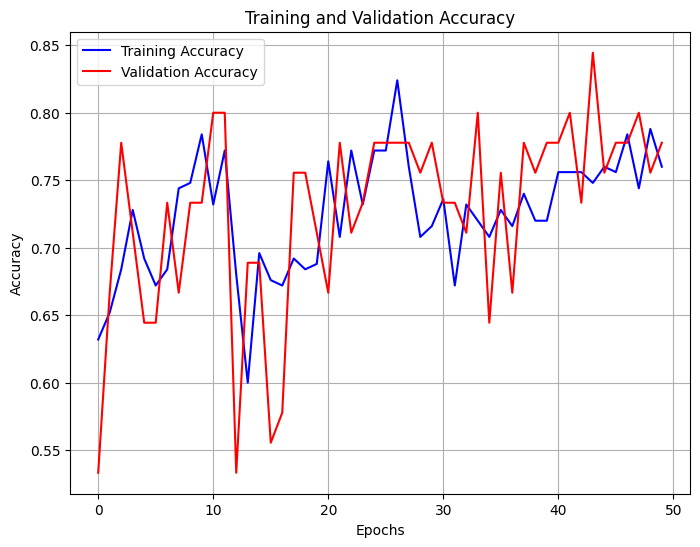

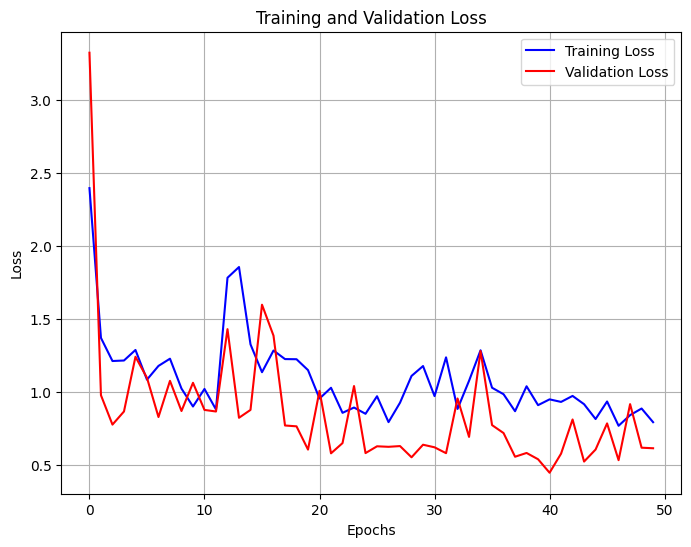

In [30]:
import matplotlib.pyplot as plt

# Print training status
print('CAE Training')

# Replace 'acc' and 'val_acc' with 'accuracy' and 'val_accuracy' for recent Keras versions
# Ensure history is defined as the output of model.fit()
acc = history.history.get('accuracy', history.history.get('acc', []))  # Fallback to 'acc' if 'accuracy' is not available
val_acc = history.history.get('val_accuracy', history.history.get('val_acc', []))  # Same for validation accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']

# Ensure accuracy and validation accuracy are available
if not acc or not val_acc:
    print("Accuracy data not found in history. Please verify the metrics used during model training.")

# Epoch range
epo = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epo, acc, 'b', label='Training Accuracy')
plt.plot(epo, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epo, loss, 'b', label='Training Loss')
plt.plot(epo, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Testing the model on test dataset

y_pred = model.predict(test_dataset, verbose=1, steps=None, max_queue_size=test_batch_size)

fpr_tf, tpr_tf, thresholds_tf = roc_curve(y_test, y_pred)

#acc_test = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
#rec = recall_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('MSE: ', mse)
print('MAE: ', mae)

37/37 [==============================] - 0s 4ms/step
MSE:  0.2675605362035088
MAE:  0.3137584782300226


In [32]:
Y_Pred = []
for x in y_pred:
    if x > 0.5:
        Y_Pred.append(1)
    else:
        Y_Pred.append(0)
print(Y_Pred)

[1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]


In [33]:
MSE = mean_squared_error(y_test, Y_Pred)
MAE = mean_absolute_error(y_test, Y_Pred)

print('MAE: ', MAE)

MAE:  0.2702702702702703


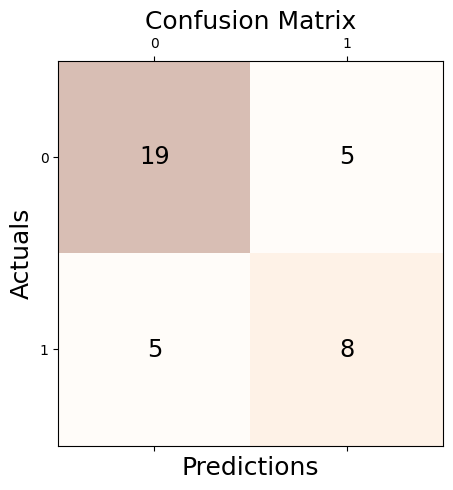

In [34]:
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=y_test, y_pred=Y_Pred)

# Print the confusion matrix using Matplotlib
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [35]:
print('Precision: %.3f' % precision_score(y_test, Y_Pred))
print('Recall: %.3f' % recall_score(y_test, Y_Pred))
print('Accuracy: %.3f' % accuracy_score(y_test, Y_Pred))
print('F1 Score: %.3f' % f1_score(y_test, Y_Pred))

Precision: 0.615
Recall: 0.615
Accuracy: 0.730
F1 Score: 0.615


In [36]:
print('Accuracy: %.3f' % balanced_accuracy_score(y_test, Y_Pred))

Accuracy: 0.704


In [37]:
Diag_column = df.loc[:, 'DX']
Diag = Diag_column.values

NameError: name 'df' is not defined

In [ ]:
diag_train = (Diag[:p1])
diag_val = (Diag[p1:p3])
diag_test = (Diag[p3:])

In [ ]:
print(diag_test)

In [ ]:
MCI_AD_test = []
MCI_AD_label = []
MCI_AD_data = []

In [ ]:
for i in range(len(diag_test)):
    if diag_test[i] == 'MCI':
        MCI_AD_test.append(x_test[i])
        MCI_AD_label.append(y_test[i])
        MCI_AD_data.append('MCI')
    elif diag_test[i] == 'Dementia':
        MCI_AD_test.append(x_test[i])
        MCI_AD_label.append(y_test[i])
        MCI_AD_data.append('Dementia')

In [ ]:
print(len(MCI_AD_test))
print(len(MCI_AD_label))
print(MCI_AD_label)
print(MCI_AD_data)

In [ ]:
test_loader = tf.data.Dataset.from_tensor_slices((MCI_AD_test, MCI_AD_label))
test_dataset = (
    test_loader.map(test_preprocessing).batch(batch_size).prefetch(batch_size)
)

In [ ]:
# Testing the model on this test dataset

y_pred = model.predict(test_dataset, verbose=1, steps=None, max_queue_size=test_batch_size)

fpr_tf, tpr_tf, thresholds_tf = roc_curve(MCI_AD_label, y_pred)

#acc_test = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#prec = precision_score(y_test, y_pred)
#rec = recall_score(y_test, y_pred)

mse = mean_squared_error(MCI_AD_label, y_pred)
mae = mean_absolute_error(MCI_AD_label, y_pred)

print('MSE: ', mse)
print('MAE: ', mae)

In [ ]:
Y_Pred = []
for x in y_pred:
    if x > 0.5:
        Y_Pred.append(1)
    else:
        Y_Pred.append(0)
print(Y_Pred)

In [ ]:
MSE = mean_squared_error(MCI_AD_label, Y_Pred)
MAE = mean_absolute_error(MCI_AD_label, Y_Pred)

print('MAE: ', MAE)

In [ ]:
# Calculate the confusion matrix

conf_matrix = confusion_matrix(y_true=MCI_AD_label, y_pred=Y_Pred)

# Print the confusion matrix using Matplotlib
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('Precision: %.3f' % precision_score(MCI_AD_label, Y_Pred))
print('Recall: %.3f' % recall_score(MCI_AD_label, Y_Pred))
print('Accuracy: %.3f' % accuracy_score(MCI_AD_label, Y_Pred))
print('F1 Score: %.3f' % f1_score(MCI_AD_label, Y_Pred))

In [ ]:
print('Accuracy: %.3f' % balanced_accuracy_score(MCI_AD_label, Y_Pred))

In [ ]:
print(MCI_AD_data)
print(MCI_AD_label)
print(Y_Pred)